In [1]:
# %matplotlib inline
from numpy.random import RandomState
import numpy
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import string
from sklearn.decomposition import TruncatedSVD

In [2]:
import os
path_to_model = 'C:/Users/prana/Desktop/BE Project/LegalBuddyServer/OPPClassifiers/SecondaryClassifiers/Models/UserChoiceandControl/ChoiceType.sav'
# os.listdir(path_to_model)

# Create Multilabel Dataset

In [3]:
#preprocess
df = pd.read_csv('dataset.csv')
df = df.dropna()

classes = list(df.Category.unique())
total_unique_clauses = df.Clause.unique().size

#creating dict for appending
classes_dict = {}
for single_class in classes:
    classes_dict[single_class] = list(numpy.zeros(total_unique_clauses))

#creating the df
data = {}
for index,row in df.iterrows():
    try : 
        data[row['Clause']].append(row['Category'])
        data[row['Clause']] = list(set(data[row['Clause']]))  
    except:
        data[row['Clause']] = [row['Category']]

        Clause = []
Category = []
for key in data.keys():
    Clause.append(key)
    Category.append(data[key])
    
data = pd.DataFrame({
    'Clause' : Clause,
    'Category' : Category
})
index = 0
for category_list in data.Category:
    for category in category_list:
        classes_dict[category][index] = 1
    index += 1

classes_dict = pd.DataFrame(classes_dict)

In [4]:
data.head()

,Clause,Category
0,opt-out,"[First-party privacy controls, Opt-out via con..."
1,opt-out of receiving promotional communication...,[Opt-out via contacting company]
2,You may at any time opt-out of receiving promo...,[Opt-out via contacting company]
3,please do not make any use of the Site.,[Dont use service/feature]
4,"If you do not agree to this Privacy Policy, pl...",[Dont use service/feature]


In [5]:
classes_dict.head()

,Opt-out via contacting company,Dont use service/feature,Opt-out link,Browser/device privacy controls,Unspecified,Opt-in,First-party privacy controls,Other,Third-party privacy controls
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
one_hot_encoded_data = pd.concat([data, classes_dict], axis=1)
one_hot_encoded_data.drop(columns=['Category']).to_csv('multilabel_dataset.csv')

In [7]:
df = pd.read_csv('multilabel_dataset.csv')
df = df.dropna()
train = df.sample(frac=0.8, random_state = RandomState())
test = df.loc[~df.index.isin(train.index)]
validation = train.sample(frac=0.2, random_state=200)

In [8]:
df.columns.values[2:]

array(['Opt-out via contacting company', 'Dont use service/feature',
       'Opt-out link', 'Browser/device privacy controls', 'Unspecified',
       'Opt-in', 'First-party privacy controls', 'Other',
       'Third-party privacy controls'], dtype=object)

# Visualizing Data

In [9]:
counts = []
categories = list(df.columns.values[2:])
for i in categories:
    counts.append((i, df[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,Opt-out via contacting company,209.0
1,Dont use service/feature,101.0
2,Opt-out link,233.0
3,Browser/device privacy controls,187.0
4,Unspecified,129.0
5,Opt-in,164.0
6,First-party privacy controls,115.0
7,Other,106.0
8,Third-party privacy controls,74.0


Text(0.5, 0, 'category')

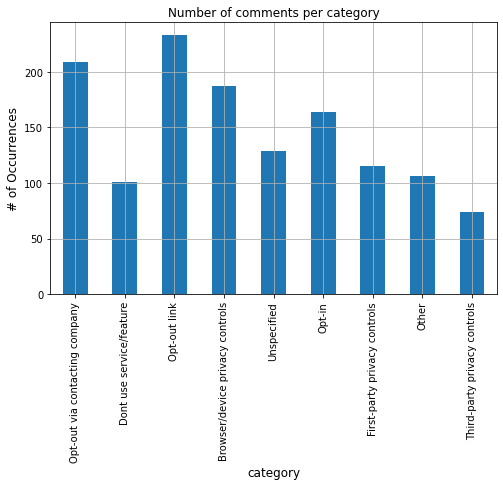

In [10]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

# Preprocessing Data

In [11]:
# cleaned_clause = []
# for clause in df.Clause:
#     clause = clause.lower()
#     clause = re.sub(r'[0-9]+', '',clause) #number removal
#     clause = clause.translate(string.maketrans(“”,””), string.punctuation) #removinf punctuations
#     clause = clause.strip() #whitespace removal
#     clause
#     break

In [12]:
x_test = test.Clause
x_train = train.Clause

In [13]:
y = train.iloc[:,2:]
y_test = test.iloc[:,2:]

categories = list(y.columns)

In [14]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(df.Clause)

<1269x1622 sparse matrix of type '<class 'numpy.float64'>'
	with 20191 stored elements in Compressed Sparse Row format>

# Naive Bayes

In [15]:
prediction_pd = {}
classifier_list_nb = []
for category in categories:
    clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_nb.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Opt-out via contacting company
Test accuracy is 0.8110236220472441
... Processing Dont use service/feature
Test accuracy is 0.9173228346456693
... Processing Opt-out link
Test accuracy is 0.8818897637795275
... Processing Browser/device privacy controls
Test accuracy is 0.9409448818897638
... Processing Unspecified
Test accuracy is 0.9330708661417323
... Processing Opt-in
Test accuracy is 0.8661417322834646
... Processing First-party privacy controls
Test accuracy is 0.9251968503937008
... Processing Other
Test accuracy is 0.905511811023622
... Processing Third-party privacy controls
Test accuracy is 0.9330708661417323


array([[[195,   2],
        [ 46,  11]],

       [[233,   0],
        [ 21,   0]],

       [[216,   1],
        [ 29,   8]],

       [[220,   1],
        [ 14,  19]],

       [[237,   0],
        [ 17,   0]],

       [[218,   0],
        [ 34,   2]],

       [[235,   0],
        [ 19,   0]],

       [[230,   0],
        [ 24,   0]],

       [[237,   0],
        [ 17,   0]]], dtype=int64)

# Linear SVC

In [16]:
prediction_pd = {}
classifier_list_svc = []
clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
for category in categories:
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_svc.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Opt-out via contacting company
Test accuracy is 0.9212598425196851
... Processing Dont use service/feature
Test accuracy is 0.9566929133858267
... Processing Opt-out link
Test accuracy is 0.9173228346456693
... Processing Browser/device privacy controls
Test accuracy is 0.9921259842519685
... Processing Unspecified
Test accuracy is 0.9015748031496063
... Processing Opt-in
Test accuracy is 0.9251968503937008
... Processing First-party privacy controls
Test accuracy is 0.9409448818897638
... Processing Other
Test accuracy is 0.9015748031496063
... Processing Third-party privacy controls
Test accuracy is 0.952755905511811


array([[[193,   4],
        [ 16,  41]],

       [[230,   3],
        [  8,  13]],

       [[210,   7],
        [ 14,  23]],

       [[220,   1],
        [  1,  32]],

       [[227,  10],
        [ 15,   2]],

       [[214,   4],
        [ 15,  21]],

       [[229,   6],
        [  9,  10]],

       [[228,   2],
        [ 23,   1]],

       [[235,   2],
        [ 10,   7]]], dtype=int64)

# Logistic Regression

In [17]:
prediction_pd = {}
classifier_list_lr = []
clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)
for category in categories:
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_lr.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Opt-out via contacting company
Test accuracy is 0.8503937007874016
... Processing Dont use service/feature
Test accuracy is 0.9330708661417323
... Processing Opt-out link
Test accuracy is 0.9094488188976378
... Processing Browser/device privacy controls
Test accuracy is 0.9724409448818898
... Processing Unspecified
Test accuracy is 0.9330708661417323
... Processing Opt-in
Test accuracy is 0.8818897637795275
... Processing First-party privacy controls
Test accuracy is 0.937007874015748
... Processing Other
Test accuracy is 0.905511811023622
... Processing Third-party privacy controls
Test accuracy is 0.9330708661417323


array([[[197,   0],
        [ 38,  19]],

       [[233,   0],
        [ 17,   4]],

       [[216,   1],
        [ 22,  15]],

       [[220,   1],
        [  6,  27]],

       [[237,   0],
        [ 17,   0]],

       [[218,   0],
        [ 30,   6]],

       [[233,   2],
        [ 14,   5]],

       [[230,   0],
        [ 24,   0]],

       [[237,   0],
        [ 17,   0]]], dtype=int64)

In [21]:
import pickle
#saving model
list_of_classifiers = classifier_list_svc
pickle.dump((tfidf, list_of_classifiers), open(path_to_model, 'wb'))

In [19]:
with open(path_to_model, 'rb') as model:
    vect, clfs = pickle.load(model)

In [20]:
clfs

[OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                  dual=False, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=None, max_iter=100,
                                                  multi_class='auto',
                                                  n_jobs=None, penalty='l2',
                                                  random_state=None,
                                                  solver='sag', tol=0.0001,
                                                  verbose=0, warm_start=False),
                     n_jobs=1),
 OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                  dual=False, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=